# Import Modules

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import * 

import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import callbacks

np.random.seed(1)
# from tensorflow.random import set_seed
# set_seed(2)

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
if __name__ == "__main__":
    print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11039048451671489384
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10937236634366741542
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 240520797775669289
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11993327776319467495
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# Data Preparation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/SemEval_2020

/content/drive/My Drive/SemEval_2020


## Read CSV Data (You can ignore this)

In [0]:
PATH_CSV = "./data_7000_processed.csv" # use pre-processed data, it ignores 26 missing images, actual enties are 6974
PATH_IMG = "./memotion_analysis_training_data/data_7000/"
trainX=[]
data = pd.read_csv(PATH_CSV, index_col=0)  
# data.columns = ['Image_name', 'Image_URL', 'OCR_extracted_text', 'corrected_text',
#        'Humour', 'Sarcasm', 'offensive', 'Motivational', 'Overall_Sentiment']
data.shape

(6974, 11)

In [0]:
data.head()

,Image_name,Image_URL,OCR_extracted_text,corrected_text,Humour,Sarcasm,offensive,Motivational,Overall_Sentiment,img_width,img_height
0,10_year_10-year-challenge_1547788782.jpeg,https://spiderimg.amarujala.com/assets/images/...,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive,749,506
1,10_year_10yearchallenge-5c75f8b946e0fb0001edc7...,https://www.lifewire.com/thmb/8wNfd94_meE9X2cp...,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive,766,571
2,10_year_10-year-challenge-sweet-dee-edition-40...,https://pics.conservativememes.com/10-year-cha...,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive,500,334
3,10_year_10-year-challenge-with-no-filter-47-hi...,https://pics.me.me/10-year-challenge-with-no-f...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral,500,429
4,10_year_10-years-challenge.jpg,https://i0.wp.com/beyondblindfold.com/wp-conte...,"What if the ""10 Year Challenge"" was created by...","What if the ""10 Year Challenge"" was created by...",hilarious,general,slight,not_motivational,very_positive,780,399


Show how many pictures in each class

In [0]:
data['Overall_Sentiment'].value_counts() #corrected data

positive         3117
neutral          2198
very_positive    1030
negative          479
very_negative     150
Name: Overall_Sentiment, dtype: int64

## Read Image data (You can ignore this)
it may crash Google colab, please import processed pickle files

In [0]:
## use cv2, and delete 2-channel error image
c = 0
size = 128,128  # img size: height, width 
X = [ ]     # creating an empty array
error = []
for img_name in tqdm(data['Image_name']):
  c += 1
#   image = Image.open(PATH_IMG + img_name)
#   img = asarray(image.resize(size))
  if(os.path.isfile(PATH_IMG + img_name)):
    image = cv2.imread((PATH_IMG + img_name), cv2.IMREAD_COLOR)
    if image is not None:
#       pass
      img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, size)
      if img.ndim != 3:                  # if the image is not RGB
        img = np.dstack([img, img, img]) # use the same value for the 3 RGB channels
      X.append(img)  # storing each image in array X
    else:
      print('None:{}'.format(img_name))
      error.append(img_name)
  else:
    print('Not Exists:{}'.format(img_name))
    error.append(img_name)
#   print(c,img.shape, img_name) # print each image infomaiton

print(error)
X = np.array(X)   # converting list to array
data = data[~data['Image_name'].isin(error)] # delete data of error images


100%|██████████| 1886/1886 [00:21<00:00, 86.94it/s]

[]


## *Or Import processed data* (use this to import data)

In [6]:
# New: Import pre-processed image data
import pickle 

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData_6988.pickle", "rb"))
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX_6988.pickle", "rb")) #import preprocessed 128*128 data


data_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialData_899.pickle", "rb"))
X_trial = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/TrialX_899.pickle", "rb"))
width, height, channels = X.shape[1:]
print(X.shape)
X = X/255
print(X_trial.shape)
X_trial = X_trial/255
data = data.reset_index(drop=True)
Y_3 = np.array(data['overall_sentiment'].replace('very_positive','positive').replace('very_negative','negative'))
data['taskA'] = Y_3
print(data['taskA'].value_counts())
Y = to_categorical(data['taskA'].factorize(sort=True)[0])
Y_trial = to_categorical(data_trial['taskA'].factorize(sort=True)[0])
# use classes weights to handle data imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_3),Y_3)
class_weights = {i : class_weights[i] for i in range(3)}
# class_weights

(6988, 128, 128, 3)
(899, 128, 128, 3)
positive    4156
neutral     2201
negative     631
Name: taskA, dtype: int64


In [0]:
# Import pre-processed image data
import pickle 

data = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewData.pickle", "rb")) # dataframe 
error = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewError.pickle", "rb"))  # error image
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainX.pickle", "rb")) #import preprocessed 128*128 data
Y_3 = pickle.load(open("/content/drive/My Drive/SemEval_2020/New_Training_Data/NewTrainY_3.pickle", "rb"))  #3-class value
width, height, channels = X.shape[1:]
X = X/255

Tranform 5-class to 3-class, use one-hot encoding, and use class_weights in training to handle data imbalance problem

In [0]:
Y_3.replace('very_positive','positive').replace('very_negative','negative')

print(Y_3.value_counts())

num_class = 3
Y = to_categorical(Y_3.factorize()[0])

# use classes weights to handle data imbalance
trainYcate3 = [np.argmax(i) for i in Y]
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(trainYcate3),trainYcate3)
class_weights

positive    4156
neutral     2201
negative     631
Name: overall_sentiment, dtype: int64


array([0.56047482, 1.05830683, 3.69149498])

In [0]:
data = data.replace('very_positive','positive').replace('very_negative','negative')
list(data.columns)
data['overall_sentiment'].value_counts()

positive    4156
neutral     2201
negative     631
Name: overall_sentiment, dtype: int64

# Modelling

## Text Data

### Text data pre-process

In [0]:
def encodeText(orig_text,max_len=0):
  t = Tokenizer()
  X_text = [str(i) for i in orig_text]
  t.fit_on_texts(X_text)
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences(X_text)
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

In [8]:
X_text, vocab_size, max_length = encodeText(data['text_corrected'])
print(vocab_size, max_length) 
X_text_trial, vocab_size_trial, max_length_trial = encodeText(data_trial['corrected_text'],192)
print(vocab_size_trial, max_length_trial) 

13367 192
1569 192


In [0]:
padded_train, vocab_size, max_length = encodeText(data['text_corrected'])

Stage 1 version

In [0]:
data_minorclass1=(data.loc[data['overall_sentiment'] == 'negative'])
data_minorclass2=(data.loc[data['overall_sentiment'] == 'neutral'])
data_majorityclass=(data.loc[data['overall_sentiment'] == 'positive'])


X1=data.drop(['overall_sentiment'], axis=1)
Xmin1=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xmin2=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xa=data_minorclass1.drop(['overall_sentiment'], axis=1)
Xb=data_minorclass2.drop(['overall_sentiment'], axis=1)
Xmaj=data_majorityclass.drop(['overall_sentiment'], axis=1)
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [0]:
padded_min1, vocab_size_min1, max_length_min1 = encodeText(Xmin1['text_corrected'])

In [0]:
padded_min2, vocab_size_min2, max_length_min2 = encodeText(Xmin2['text_corrected'])

In [0]:
padded_maj, vocab_size_maj, max_length_maj = encodeText(Xmaj['text_corrected'])

In [0]:
# get text vector data
Xa=padded_min1
Xb=padded_min2
Xmaj=padded_maj

In [0]:
# target value for each class
ymin1=data_minorclass1.overall_sentiment
ymin2=data_minorclass2.overall_sentiment
ymaj=data_majorityclass.overall_sentiment

In [0]:
#GMM
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 8
from sklearn.mixture import GaussianMixture

#train-test split for each class
X_train_min1, X_test_min1, y_train_min1, y_test_min1 = train_test_split(Xa, ymin1, test_size=0.2, random_state=0)
X_train_min2, X_test_min2, y_train_min2, y_test_min2 = train_test_split(Xb, ymin2, test_size=0.2, random_state=0)
X_train_maj, X_test_maj, y_train_maj, y_test_maj = train_test_split(Xmaj, ymaj, test_size=0.2, random_state=0)


In [16]:
# dimensions reduction by PCA
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
print(X_train_min1.shape)
Xmin1 = pca.fit_transform(X_train_min1)
print(Xmin1.shape)

(384, 59)
(384, 34)


In [17]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(Xmin1)
# print(gmm.converged_)
# print (gmm.means_)
# print (gmm.covariances_)

#upsampling
datanew1 = gmm.sample(len(X_train_maj)-len(X_train_min1)) #new data
new_x1, x2 = datanew1
print(new_x1.shape)

# inverse PCA for new data
new_X1 = pca.inverse_transform(new_x1)
print(new_X1.shape)



(2115, 34)
(2115, 59)


In [18]:
#inverse PCA for orignal training set
X_train_min= pca.inverse_transform(Xmin1)

os_data_X1 = pd.DataFrame(data=new_X1)
X_train_min = pd.DataFrame(data=X_train_min)

#merve original training set with new sampling data
X_osmin1=X_train_min.merge(os_data_X1, how='outer')
print(X_osmin1.shape)

(2499, 59)


In [23]:
len(y_train_maj)

2499

In [0]:
#Build the target value with the same length as the major class
new_Ymaj=[]
for i in y_train_maj:
    y='positive'
    new_Ymaj.append(y)

os_data_y= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])
y_train_maj1= pd.DataFrame(data=new_Ymaj,columns=['overall_sentiment'])

In [24]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
Xmin2 = pca.fit_transform(X_train_min2)
X_train_min2.shape,Xmin2.shape

((1760, 72), (1760, 37))

In [25]:
gmm2 = GaussianMixture(2, covariance_type='full', random_state=0)
gmm2.fit(Xmin2)
# print(gmm2.converged_)
# print (gmm2.means_)
# print (gmm2.covariances_)
datanew2 = gmm2.sample(len(X_train_maj)-len(X_train_min2))
new_x2, x3 = datanew2
#print(new_x2)
new_X2 = pca.inverse_transform(new_x2)
print(new_X2.shape)

(739, 72)


In [26]:
X_train_min2= pca.inverse_transform(Xmin2)
os_data_X2 = pd.DataFrame(data=new_X2)
X_train_min2= pd.DataFrame(data=X_train_min2)
X_osmin2=X_train_min2.merge(os_data_X2, how='outer')
print(X_osmin2.shape)

(2499, 72)


In [0]:
X_osmin=X_osmin1.merge(X_osmin2, how='outer') #merge data will keep the max length, and leave NaN data

In [28]:
X_osmin.iloc[:,62:]

,62,63,64,65,66,67,68,69,70,71
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4993,0.375217,0.006469,7.006198,2.361276,0.025877,40.788625,0.064693,0.006469,40.795094,6.119911
4994,-0.457378,-0.007886,-8.540349,-2.878326,-0.031543,-49.720129,-0.078858,-0.007886,-49.728015,-7.459991
4995,3.531824,0.060894,65.947682,22.226135,0.243574,383.933643,0.608935,0.060894,383.994536,57.605270
4996,-0.145089,-0.002502,-2.709162,-0.913060,-0.010006,-15.772177,-0.025015,-0.002502,-15.774678,-2.366452


In [0]:
Xmaj1= pd.DataFrame(data=X_train_maj)

In [30]:
print('min,max in minor class 1:',X_osmin1.values.min(),X_osmin1.values.max())
print('min,max in minor class 2:',X_osmin2.values.min(),X_osmin2.values.max())
print('min,max in major class:',X_train_maj.min(),X_train_maj.max())

min,max in minor class 1: -2169.2151878106547 3362.429373008541
min,max in minor class 2: -4841.183186082956 7231.333694726491
min,max in major class: 0 8236


In [31]:
X_os=X_osmin.merge(Xmaj1, how='outer')
X_os.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


(7497, 192)

In [0]:
new_Ymin1=[]
for i in y_train_maj:
    y='negative'
    new_Ymin1.append(y)



os_ymin1= pd.DataFrame(data=new_Ymin1,columns=['overall_sentiment'])




In [33]:
os_ymin1.shape

(2499, 1)

In [0]:
new_Ymin2=[]
for i in y_train_maj:
    y='neutral'
    new_Ymin2.append(y)



os_ymin2= pd.DataFrame(data=new_Ymin2,columns=['overall_sentiment'])




In [35]:
os_ymin2.shape

(2499, 1)

In [0]:
y_nn=os_ymin1.merge(os_ymin2,how='outer')

In [0]:
y_os=y_nn.merge(y_train_maj,how='outer')

In [0]:
num_class = 3
Ys=pd.get_dummies(y_os)


In [0]:
y_test_maj= pd.DataFrame(data=y_test_maj,columns=['overall_sentiment'])
y_test_min1= pd.DataFrame(data=y_test_min1,columns=['overall_sentiment'])
y_test_min2= pd.DataFrame(data=y_test_min2,columns=['overall_sentiment'])
y_test_nn=y_test_min1.merge(y_test_min2,how='outer')
y_test_total=y_test_nn.merge(y_test_maj,how='outer')

X_test_min1= pd.DataFrame(data=X_test_min1)
X_test_min2= pd.DataFrame(data=X_test_min2)
X_test_maj= pd.DataFrame(data=X_test_maj)
X_test_Val1=X_test_min1.merge(X_test_min2,how='outer')
X_test_Val_t=X_test_Val1.merge(X_test_maj,how='outer')


In [0]:
y_test_total1=pd.get_dummies(y_test_total)

Following are test only models

### Model 1.1 - Embedding+LSTM

In [42]:
np.random.seed(1)
# set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'
            #  ,keras.metrics.Precision(name='precision'),
                  # keras.metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 192, 100)          1336700   
_________________________________________________________________
dropout_3 (Dropout)          (None, 192, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 192, 128)          117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1572928   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [43]:
X_os.shape, Ys.shape

((7497, 192), (7497, 3))

In [44]:
X_test_Val_t.shape, y_test_total1.shape

((1162, 192), (1162, 3))

In [45]:
results = model.fit(X_os, Ys, epochs=10, shuffle=True, validation_data=(X_test_Val_t,y_test_total1), batch_size=64)

Epoch 1/10


InvalidArgumentError: ignored

In [0]:
model.evaluate(X_text_trial,Y_trial)

899/899 [==============================] - 3s 3ms/sample - loss: 7.2532 - acc: 0.6129


[7.253179174641746, 0.61290324]

In [0]:
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.6129032258064516 0.25333333333333335


In [0]:
# training data
trainset = model.fit(padded_train, Y, epochs=10, batch_size=64, validation_split=0.2 )

Train on 5590 samples, validate on 1398 samples
Epoch 1/10
5590/5590 [==============================] - 9s 2ms/sample - loss: 0.9051 - acc: 0.5882 - val_loss: 0.8781 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 4s 646us/sample - loss: 0.8617 - acc: 0.5993 - val_loss: 0.9242 - val_acc: 0.6009
Epoch 3/10
5590/5590 [==============================] - 4s 649us/sample - loss: 0.6021 - acc: 0.7449 - val_loss: 1.1193 - val_acc: 0.5193
Epoch 4/10
5590/5590 [==============================] - 4s 649us/sample - loss: 0.2991 - acc: 0.8882 - val_loss: 1.7445 - val_acc: 0.5243
Epoch 5/10
5590/5590 [==============================] - 4s 646us/sample - loss: 0.1524 - acc: 0.9460 - val_loss: 1.9656 - val_acc: 0.4707
Epoch 6/10
5590/5590 [==============================] - 4s 650us/sample - loss: 0.1011 - acc: 0.9687 - val_loss: 2.1285 - val_acc: 0.4785
Epoch 7/10
5590/5590 [==============================] - 4s 647us/sample - loss: 0.0664 - acc: 0.9809 - val_loss: 2.4064 - val_

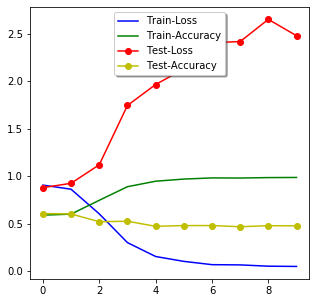

In [0]:
plt.figure(figsize=(5,5))
plt.plot(list(trainset.history.values())[0],'b',label='Train-Loss')
plt.plot(list(trainset.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(trainset.history.values())[2],'r-o',label='Test-Loss')
plt.plot(list(trainset.history.values())[3],'y-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 1.2 - Embedding+Conv1D  

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
model.add(Dropout(0.2))

model.add(Conv1D(128, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))

model.add(Dense(3, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 192, 50)           668350    
_________________________________________________________________
dropout_17 (Dropout)         (None, 192, 50)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 190, 128)          19328     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 387       
Total params: 704,577
Trainable params: 704,577
Non-trainable params: 0
________________________________________________

In [0]:
results = model.fit(X_os, Ys, epochs=10, shuffle=True, validation_data=(X_test_Val_t,y_test_total1), batch_size=64)

Train on 7497 samples, validate on 1162 samples
Epoch 1/10
7497/7497 [==============================] - 2s 278us/sample - loss: 0.7692 - acc: 0.7122 - val_loss: 1.7051 - val_acc: 0.4466
Epoch 2/10
7497/7497 [==============================] - 1s 119us/sample - loss: 0.2397 - acc: 0.9242 - val_loss: 2.9096 - val_acc: 0.5060
Epoch 3/10
7497/7497 [==============================] - 1s 120us/sample - loss: 0.1615 - acc: 0.9498 - val_loss: 3.5009 - val_acc: 0.5207
Epoch 4/10
7497/7497 [==============================] - 1s 119us/sample - loss: 0.1313 - acc: 0.9580 - val_loss: 3.5654 - val_acc: 0.5052
Epoch 5/10
7497/7497 [==============================] - 1s 120us/sample - loss: 0.1088 - acc: 0.9627 - val_loss: 3.9760 - val_acc: 0.5155
Epoch 6/10
7497/7497 [==============================] - 1s 118us/sample - loss: 0.0995 - acc: 0.9675 - val_loss: 4.0177 - val_acc: 0.4948
Epoch 7/10
7497/7497 [==============================] - 1s 118us/sample - loss: 0.0822 - acc: 0.9732 - val_loss: 3.7500 - va

In [0]:
results = model.fit(X_os, Ys, epochs=10, batch_size=64, validation_data=(X_test_Val_t, y_test_total1))

Train on 9972 samples, validate on 1400 samples
Epoch 1/10
9972/9972 [==============================] - 1s 95us/sample - loss: 0.5693 - acc: 0.7211 - val_loss: 2.8456 - val_acc: 0.5943
Epoch 2/10
9972/9972 [==============================] - 1s 74us/sample - loss: 0.2656 - acc: 0.8830 - val_loss: 3.2894 - val_acc: 0.5943
Epoch 3/10
9972/9972 [==============================] - 1s 74us/sample - loss: 0.1635 - acc: 0.9345 - val_loss: 2.9138 - val_acc: 0.5936
Epoch 4/10
9972/9972 [==============================] - 1s 74us/sample - loss: 0.0954 - acc: 0.9655 - val_loss: 3.2821 - val_acc: 0.5914
Epoch 5/10
9972/9972 [==============================] - 1s 77us/sample - loss: 0.0509 - acc: 0.9849 - val_loss: 3.4206 - val_acc: 0.5914
Epoch 6/10
9972/9972 [==============================] - 1s 75us/sample - loss: 0.0290 - acc: 0.9913 - val_loss: 3.4560 - val_acc: 0.5900
Epoch 7/10
9972/9972 [==============================] - 1s 75us/sample - loss: 0.0131 - acc: 0.9971 - val_loss: 3.4754 - val_acc: 

In [0]:
model.evaluate(X_text_trial,Y_trial)


899/899 [==============================] - 0s 98us/sample - loss: 5.6398 - acc: 0.5606


[5.639836698074362, 0.56062293]

In [0]:
temp = model.predict(X_text_trial)
temp_pre = [np.argmax(i) for i in temp]
temp_truth = [np.argmax(i) for i in Y_trial]
print(accuracy_score(temp_pre, temp_truth),f1_score(temp_pre, temp_truth, average='macro'))

0.560622914349277 0.2711962068883667


### Model 1.3 - Embedding+LSTM+Conv1D

In [0]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length))
# model.add(Dropout(0.1))
model.add(CuDNNLSTM(128, return_sequences=True))

model.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

model.add(Dense(250, activation='relu'))

model.add(Dense(3, activation='softmax'))
model.compile(loss = "categorical_crossentropy",  #sparse_categorical_crossentropy
             optimizer = 'adam',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 192, 50)           668800    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 192, 128)          92160     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 190, 250)          96250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 250)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               62750     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 753       
Total params: 920,713
Trainable params: 920,713
Non-trainable params: 0
________________________________________________

In [0]:
results = model.fit(X_os, Ys, epochs=10, batch_size=64, validation_data=(X_test_Val_t, y_test_total1) )

Train on 9972 samples, validate on 1400 samples
Epoch 1/10
9972/9972 [==============================] - 8s 766us/sample - loss: 0.5876 - acc: 0.6697 - val_loss: 2.4493 - val_acc: 0.5921
Epoch 2/10
9972/9972 [==============================] - 2s 239us/sample - loss: 0.3282 - acc: 0.8577 - val_loss: 2.3816 - val_acc: 0.5757
Epoch 3/10
9972/9972 [==============================] - 2s 243us/sample - loss: 0.1986 - acc: 0.9252 - val_loss: 4.5758 - val_acc: 0.5929
Epoch 4/10
9972/9972 [==============================] - 2s 242us/sample - loss: 0.0973 - acc: 0.9659 - val_loss: 6.4341 - val_acc: 0.5850
Epoch 5/10
9972/9972 [==============================] - 2s 245us/sample - loss: 0.0530 - acc: 0.9818 - val_loss: 5.3215 - val_acc: 0.5929
Epoch 6/10
9972/9972 [==============================] - 2s 245us/sample - loss: 0.0350 - acc: 0.9879 - val_loss: 6.2847 - val_acc: 0.5929
Epoch 7/10
9972/9972 [==============================] - 2s 243us/sample - loss: 0.0190 - acc: 0.9945 - val_loss: 7.1543 - va

## Image Data
Following are image only models

### Model 2.1 - CIFAR10 CNN 
Conv-Conv-Maxpool-Dense
https://keras.io/examples/cifar10_cnn/

In [0]:
# define model
from keras import regularizers
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
# model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
# model.add(Dropout(0.2))


model.add(Dense(3, activation='softmax'))
opt = Adam(lr=0.001, decay=1e-6)


In [0]:

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
results = model.fit(X_os, Ys, epochs=10, batch_size=64, validation_data=(X_test_Val_t, y_test_total1) )

ValueError: ignored

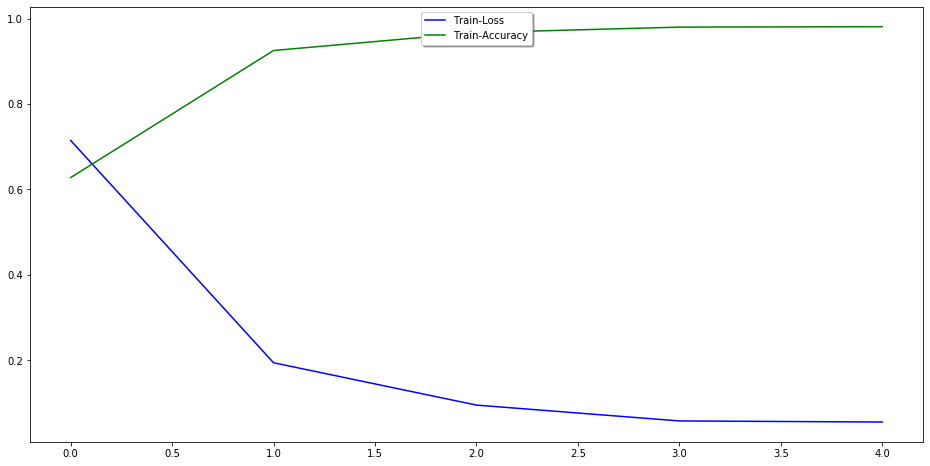

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

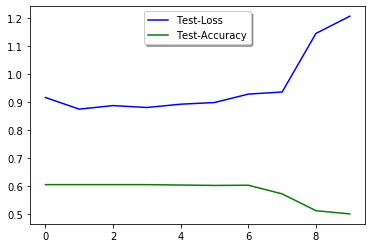

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 2.2 (Siyuan)
Conv32-Conv64-Conv128-Dense128 (image only)

In [0]:
# 3 Conv model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',input_shape=(64,64, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((9972, 192)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

ValueError: ignored

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X_os, Ys,
         epochs=10,
         batch_size=64,
         
         )

ValueError: ignored

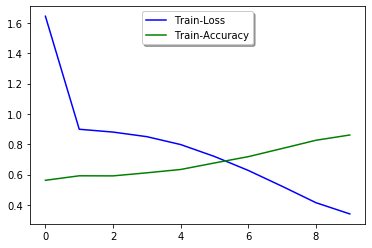

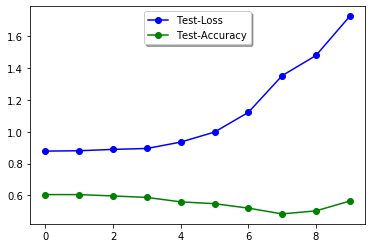

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()
plt.plot(list(results.history.values())[2],'b-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.show()

### Model 2.3 - CNN test

Conv32-Maxpool-Conv64-Maxpool-Dense128

In [0]:
# define model

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(width, height, channels)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [0]:
es = callbacks.EarlyStopping(monitor='loss', mode='min')
results = model.fit(X, Y,
         epochs=10,
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         callbacks=[es],
        class_weight=class_weights,
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/10
5590/5590 [==============================] - 3s 608us/sample - loss: 1.3174 - acc: 0.5782 - val_loss: 0.8743 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 3s 557us/sample - loss: 0.9040 - acc: 0.5921 - val_loss: 0.9005 - val_acc: 0.6052
Epoch 3/10
5590/5590 [==============================] - 3s 549us/sample - loss: 0.8947 - acc: 0.5921 - val_loss: 0.8999 - val_acc: 0.6052
Epoch 4/10
5590/5590 [==============================] - 3s 555us/sample - loss: 0.8838 - acc: 0.5943 - val_loss: 0.8863 - val_acc: 0.6030
Epoch 5/10
5590/5590 [==============================] - 3s 551us/sample - loss: 0.8615 - acc: 0.6030 - val_loss: 0.9031 - val_acc: 0.5937
Epoch 6/10
5590/5590 [==============================] - 3s 556us/sample - loss: 0.8315 - acc: 0.6161 - val_loss: 0.9105 - val_acc: 0.5758
Epoch 7/10
5590/5590 [==============================] - 3s 557us/sample - loss: 0.7822 - acc: 0.6426 - val_loss: 0.9737 - va

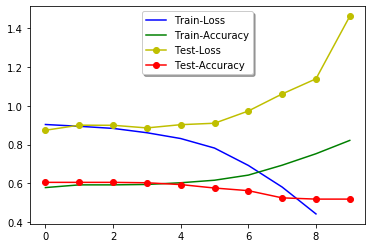

In [0]:
plt.plot(list(results.history.values())[0][1:],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Prepare CapsuleNets

these module import codes may effect other non-capsule models. When you done training capsule models, please run the first code block "Import module" at the beginning

In [0]:
from __future__ import print_function
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x
# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)

# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
#     L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
#     return L

In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3)) #重新排序维度

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
#             o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            o = self.activation(tf.keras.backend.batch_dot(c, hat_inputs, [2, 2]))
#             #新版的Keras batch_dot 的结果和原作者expected shape不同
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(o, hat_inputs, [2, 3])
#                 b = K.batch_dot(o, hat_inputs, [2, 3])
        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

### Model 2.4 - CapsNet+Imgage
adapted from keras cifar10 model

In [0]:
batch_size = 64
epochs = 10
num_class = 3

# A common Conv2D model
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


x = Reshape((-1, 128))(x)
capsule = Capsule(num_class, 32, 5, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# we use a margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
# model.summary()

In [0]:
results = model.fit(
        X,
        Y,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5590 samples, validate on 1398 samples
Epoch 1/10





5590/5590 [==============================] - 12s 2ms/step - loss: 0.7470 - acc: 0.5454 - val_loss: 0.7963 - val_acc: 0.6052
Epoch 2/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7662 - acc: 0.4070 - val_loss: 0.7928 - val_acc: 0.6052
Epoch 3/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.7903 - acc: 0.5921 - val_loss: 0.8097 - val_acc: 0.6052
Epoch 4/10
5590/5590 [==============================] - 10s 2ms/step - loss: 0.8096 - acc: 0.5921 - val_loss: 0.8094 - val_acc: 0.6052
Epoch 5/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5796 - val_loss: nan - val_acc: 0.6052
Epoch 6/10
5590/5590 [==============================] - 10s 2ms/step - loss: nan - acc: 0.5921 - val_loss: nan - val_acc: 0.6052
Epoch 7/10
5590/5590 [==============================

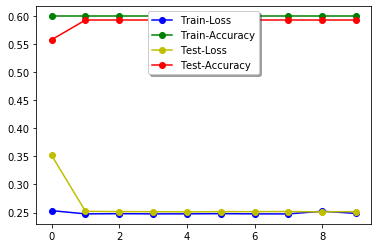

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

CapsNet + Image + Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the data
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

    # Fit the model on the batches generated by datagen.flow().
results = model.fit_generator(
        datagen.flow(trainX, trainY, batch_size=batch_size),
        epochs=epochs,
        validation_data=(testX, testY),
        workers=4)


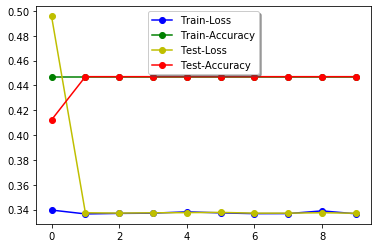

In [0]:
plt.plot(list(results.history.values())[0],'b-o',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g-o',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)
plt.plot(list(results.history.values())[2],'y-o',label='Test-Loss')
plt.plot(list(results.history.values())[3],'r-o',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

## Image + Text Fusion



In [0]:
#text data
print(padded_train.shape)
#image data
print(X.shape, Y.shape)

(6988, 192)
(6988, 128, 128, 3) (6988, 3)


#### Model 3.1 - Concat CNN+LSTM

In [0]:
a = input_text = Input(shape = max_length)
a = Embedding(vocab_size, 100)(a)
a = CuDNNLSTM(128, return_sequences=True)(a)
a = CuDNNLSTM(128)(a)
a = Flatten()(a)
a = Dense(128, activation='relu')(a)

b = input_img = Input(shape = (width, height, channels))
b = Conv2D(32, (3, 3), activation='relu')(b)
b = Dropout(0.2)(b)
b = MaxPooling2D((2,2))(b)
b = Conv2D(64, (3, 3), activation='relu')(b)
b = MaxPooling2D((2,2))(b)
b = Flatten()(b)
b = Dense(128, activation='relu')(b)

combine = Concatenate(axis=-1,)([a,b])
combine = Dense(64, activation='relu')(combine)
combine = Dropout(0.2)(combine)
combine = Dense(32, activation='relu')(combine)
combine = Dropout(0.2)(combine)
output = Dense(3, activation='softmax')(combine)
Model_text_img_clr = Model([input_text,input_img],output)
Model_text_img_clr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
Model_text_img_clr.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 126, 126, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 192)]        0                                            
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 126, 126, 32) 0           conv2d_15[0][0]                  
____________________________________________________________________________________________

In [0]:
results = Model_text_img_clr.fit([padded_train,X], Y,
         epochs=3, #14 0.5122
         batch_size=64,
         shuffle=True,
        validation_split=0.2,
         class_weight=class_weights
         )

Train on 5590 samples, validate on 1398 samples
Epoch 1/3
5590/5590 [==============================] - 13s 2ms/sample - loss: 1.0445 - acc: 0.5685 - val_loss: 0.8741 - val_acc: 0.6052
Epoch 2/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.9057 - acc: 0.5916 - val_loss: 0.8731 - val_acc: 0.6052
Epoch 3/3
5590/5590 [==============================] - 6s 1ms/sample - loss: 0.8967 - acc: 0.5918 - val_loss: 0.8824 - val_acc: 0.6052


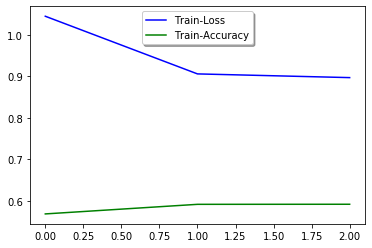

In [0]:
plt.plot(list(results.history.values())[0],'b',label='Train-Loss')
plt.plot(list(results.history.values())[1],'g',label='Train-Accuracy')
plt.legend(loc='upper center', shadow=True)

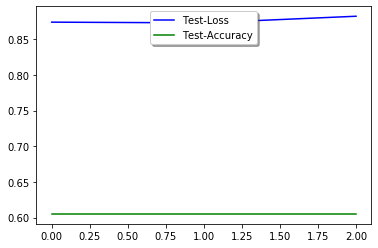

In [0]:
plt.plot(list(results.history.values())[2],'b',label='Test-Loss')
plt.plot(list(results.history.values())[3],'g',label='Test-Accuracy')
plt.legend(loc='upper center', shadow=True)

### Model 3.2 - CapsNet+Text+Img
Run the "Prepare CapsuleNets" block before training this model 

In [0]:
num_class = 5

t = input_text = Input(shape = (max_length,))
t = Embedding(vocab_size, 50)(t)
t = Dropout(0.2)(t)
t = CuDNNLSTM(64, return_sequences=True)(t)
t = Flatten()(t)

# t = Conv1D(128, 3, padding='valid', activation='relu', strides=1)(t)
# t = GlobalMaxPooling1D()(t)
# t = Dense(128, activation='relu')(t)

x = input_image = Input(shape=(width, height, channels))
t = Dropout(0.2)(t)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

combine = Concatenate(axis=-1,)([t,x])
combine = Dense(128, activation='relu')(combine)
combine = Reshape((-1, 64))(combine)

capsule = Capsule(num_class, 16, 3, True)(combine)

output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)

Model6 = Model([input_text,input_image], output)
Model6.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
Model6.summary()

In [0]:
results = Model6.fit(
        [padded_train,X],
        Y,
        batch_size=64,
        epochs=10,
        validation_split=0.2,
#         validation_data=(testX, testY),
        shuffle=True,
#         class_weight=class_weights
)

# Manual Test

## Result Analysis

Not suitable for Img+text fusion models

In [0]:
def resultAnalysis(model, data_x, data_y): # you should use seperated test data
  y_pred = model.predict(testX)
  y_pred_cate = [np.argmax(i) for i in y_pred]
  print("Prediction classes count:\n",pd.Series(y_pred_cate).value_counts())
  y_truth = [np.argmax(i) for i in testY]
  print("\nTest classes count:\n",pd.Series(y_truth).value_counts())
  print(classification_report(y_truth,y_pred_cate))

In [0]:
resultAnalysis(model, X, Y) # just a example, should use test set

Prediction classes count:
 0    838
1    457
2    103
dtype: int64

Test classes count:
 0    832
1    440
2    126
dtype: int64
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       832
           1       0.81      0.84      0.82       440
           2       0.88      0.72      0.79       126

    accuracy                           0.87      1398
   macro avg       0.87      0.82      0.84      1398
weighted avg       0.87      0.87      0.87      1398



# Load model and test data



In [0]:
#load test data
import pickle 
X = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestX.pickle", "rb"))
data = pickle.load(open("/content/drive/My Drive/SemEval_2020/TestData.pickle", "rb"))
# X = X/255

#load trained a model
# from tensorflow.keras import models
# model = models.load_model('/content/drive/My Drive/SemEval_2020/models/Model_4_img_text.h5')

In [0]:
data.shape, X.shape,X.min(),X.max()

((1878, 4), (1877, 128, 128, 3), 0, 255)

In [0]:
data.head(2)

,Image_name,Image_URL,OCR_extracted_text,corrected_text
0,chuck_chuck_norris_meme_10.jpg,https://gtmemes.com/wp-content/uploads/2019/03...,Some magicians can walk on water Chuck Norris...,Some magicians can walk on water Chuck Norris...
1,dr_evil_NDBB96K.png,https://i.imgur.com/NDBB96K.png,ONE MILLION DOLLARS made on imgur,ONE MILLION DOLLARS made on imgur


In [0]:
padded_test, vocab_size, max_length = encodeText(data['corrected_text'])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 192, 100)          1337600   
_________________________________________________________________
dropout_4 (Dropout)          (None, 192, 100)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 192, 128)          117760    
_________________________________________________________________
dropout_5 (Dropout)          (None, 192, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                786464    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

In [0]:
padded_test.shape

(1878, 192)

In [0]:
prediction = model.predict(padded_test)
prediction.shape

(1878, 3)

In [0]:
Model_text_img_clr.summary()

In [0]:
prediction = Model_text_img_clr.predict([padded_train[1:],X])
prediction.shape

(1877, 3)

In [0]:
prediction

array([[1.8817855e-15, 6.5804393e-08, 9.9999988e-01],
       [6.1161053e-13, 4.0618623e-08, 1.0000000e+00],
       [1.4230430e-13, 8.4677232e-10, 1.0000000e+00],
       ...,
       [9.8937471e-06, 2.9862896e-08, 9.9999011e-01],
       [7.3902574e-18, 6.6504660e-09, 1.0000000e+00],
       [9.9676704e-01, 2.0277915e-03, 1.2051699e-03]], dtype=float32)

In [0]:
temp_pre = [np.argmax(i) for i in prediction]
pd.Series(temp_pre).value_counts()

2    1852
0      16
1      10
dtype: int64

In [0]:
temp_pre.insert(0,0)
len(temp_pre)

1878

In [0]:
res = pd.DataFrame(temp_pre)
res[1] = [9999 for i in range(len(res))]
res[2] = [9999 for i in range(len(res))]
res = res.replace(2,-1).replace(0,'p').replace(1,0).replace('p',1)
res[0].value_counts()

-1    1852
 1      16
 0      10
Name: 0, dtype: int64

In [0]:
res.shape
# create submission file 
res.to_csv('task8A_balanced_data.txt',header=False,index=False,sep='_')
